# Data Science Aplicada à Área de Saúde

## Visualização de Dados

### Internações / Alta Hospitalar em Centros de Tratamento de Abuso de Substâncias e Saúde Mental

Faremos a importação do conjunto de dados Treatment Episode Data Set: Discharges (TEDS-D) do Arquivo de Dados de Abuso de Substâncias e Saúde Mental (SAMHDA): uma coleção de dados sobre inernações e altas hospitalares de centros americanos de tratamento de abuso de substâncias documentados em 2014. 

Criaremos diversos gráficos para visualizar várias medidas de tratamento coletadas.

Além disso, as entradas de dados representam episódios de tratamento em vez de indivíduos, que podem, portanto, ser representados mais de uma vez para diferentes episódios, e não há rastreamento de indivíduos no conjunto de dados.

Em geral, os centros que relatam dados do TEDS são aqueles que recebem fundos estaduais de agências de controle de álcool e / ou drogas (incluindo fundos federais de subsídios) para a prestação de serviços de tratamento de controle de álcool e / ou drogas. Alguns estados relatam apenas admissões financiadas publicamente; outros podem relatar todas as admissões (públicas e privadas) em instalações que recebem fundos públicos. Todos os dados relatados ao TEDS são provenientes dos sistemas de dados administrativos do estado.

Site oficial: https://datafiles.samhsa.gov/study-series/treatment-episode-data-set-discharges-teds-d-nid13520.

### Carregando os Dados

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [3]:
pd.__version__

'1.0.1'

In [4]:
np.__version__

'1.18.1'

In [5]:
import matplotlib as m
m.__version__

'3.2.0'

In [6]:
# Carrega o dataset
dataset = pd.read_csv('dados/TEDS-D-2014-DS0001-data-excel.csv')

In [7]:
# Armazena o arquivo em um banco de dados para facilitar a manipulação
connection = sqlite3.connect("TEDS_DB.sqlite")  
cur = connection.cursor()  

In [8]:
# Cria uma tabela para receber os dados
cur.execute("DROP TABLE IF EXISTS TEDSD_TB");
dataset.to_sql(name = "TEDSD_TB", con = connection) 

In [9]:
# Apaga o dataframe do Pandas para liberar a memória do computador
del(dataset)

## Quantos episódios de tratamento foram documentados em cada estado / território?

In [10]:
# Cria um dicionário para a codificação numérica de estados (obtida no livro de códigos TEDS-D)
State_dict = {1:"Alabama",2:"Alaska", 4:"Arizona", 5:"Arkansas", 6:"California", 8:"Colorado", 9:"Connecticut",
             10:"Delaware", 11: "District of Columbia", 12: "Florida", 15:"Hawaii", 16:"Idaho", 17:"Illinois",
             18:"Indiana", 19:"Iowa", 21:"Kentucky", 22:"Louisiana", 23:"Maine", 24:"Maryland", 25:"Massachusetts",
             26: "Michigan", 27:"Minnesota", 28:"Mississippi", 29:"Missouri", 30:"Montana", 31:"Nebraska", 
             32:"Nevada", 33:"New Hampshire", 34:"New Jersey", 35:"New Mexico", 36:"New York", 37:"North Carolina",
             38:"North Dakota", 39:"Ohio", 40:"Oklahoma", 41: "Oregon", 42: "Pennsylvania", 44:"Rhode Island", 
             45: "South Carolina", 46:"South Dakota", 47:"Tennessee", 48:"Texas", 49:"Utah", 50:"Vermont", 
             51:"Virginia", 53:"Washington", 54:"West Virginia", 55:"Wisconsin", 56: "Wyoming", 72:"Puerto Rico"}

In [11]:
# Coleta os dados do banco de dados
cur.execute("SELECT REGION,STFIPS,COUNT(CASEID) from TEDSD_TB group by REGION,STFIPS");
state_table_with_codes = cur.fetchall()

In [12]:
# Cria um dicionário de cores para as regiões
region_color = {0:'black', 1:'blue', 2:'red', 3:'green', 4:'cyan'}

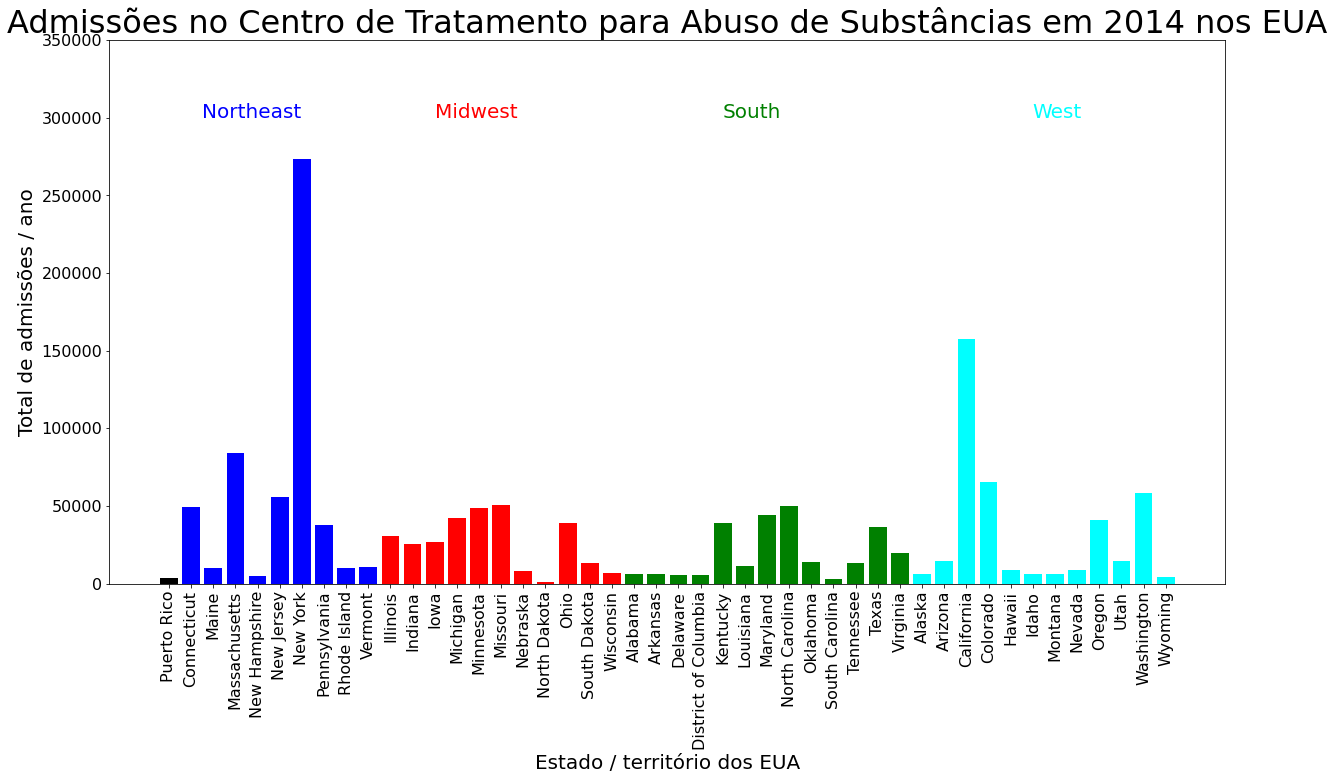

In [13]:
# Cria o plot com cores diferentes para diferentes regiões do país

# Listas vazias
colors = []
states = []
episodes = []

# Loop nos dados para alimentar as listas
for entry in state_table_with_codes:
    colors.append(region_color[entry[0]])
    states.append(State_dict[entry[1]])
    episodes.append(entry[2])

# Plot
plt.figure(figsize=(20,10))
plt.bar(states, episodes, color=colors)
plt.xticks(rotation=90, fontsize = 16);
plt.yticks(fontsize=16)
plt.title("Admissões no Centro de Tratamento para Abuso de Substâncias em 2014 nos EUA", fontsize = 32);
plt.xlabel("Estado / território dos EUA", fontsize = 20)
plt.ylabel("Total de admissões / ano", fontsize = 20);
plt.ylim(0,350000)
plt.text(1.5, 300000, "Northeast", color='blue',fontsize=20);
plt.text(12, 300000, "Midwest", color='red', fontsize=20);
plt.text(25, 300000, "South", color='green', fontsize=20);
plt.text(39, 300000, "West", color='cyan', fontsize=20);
plt.show()

Observe que alguns estados têm muito mais admissões do que outros. Isso pode ser devido à diferença no tamanho da população entre os estados, bem como a outros fatores, como relatar diferenças ou acessibilidade dos centros de tratamento com financiamento público.

Para analisar melhor, normalizaremos os dados dividindo por população do estado e obteremos as "admissões per capita" de cada estado.

## Quantos episódios de tratamento foram documentados em cada estado / território por pessoa por ano?

In [14]:
# Carregando os dados de população por estado americano
STATEPOPS = pd.read_csv('dados/populacao_estados_usa.csv')

In [15]:
# Armazenamos os dados da população por estado em nosso banco de dados
cur.execute("DROP TABLE IF EXISTS STATEPOPS");
STATEPOPS.to_sql(name = "STATEPOPS", con = connection) ;

In [16]:
# Buscamos os dados da população por estado dos dados sql e armazenamos em um dicionário
cur.execute("SELECT STATE, POPULATION from STATEPOPS");
STATEPOPSlist = cur.fetchall()

# Cria um dicionário vazio
STATEPOPSdict = dict()

# Alimenta os dados da lista no dicionário usando estado como índice
for (state, pop) in STATEPOPSlist:
    STATEPOPSdict[state] = pop

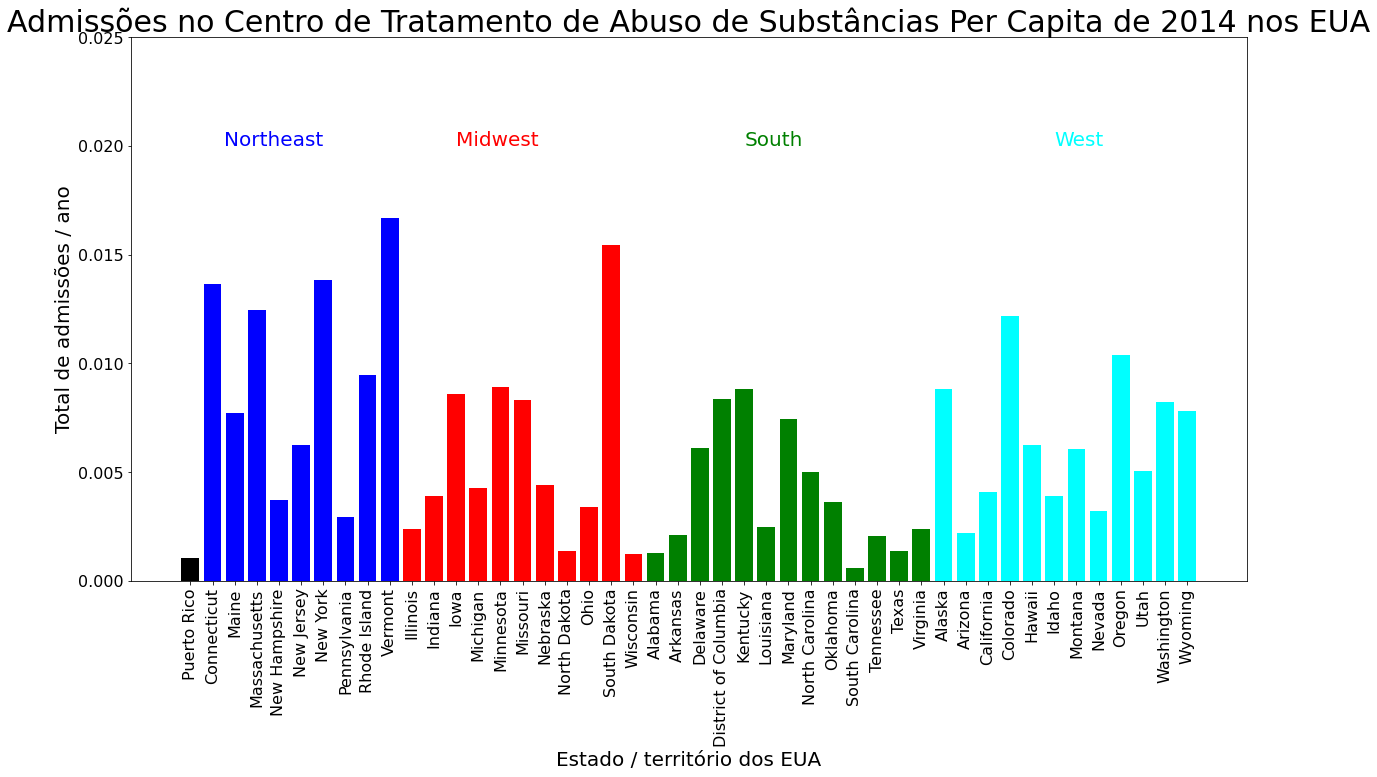

In [17]:
# Plot

# Listas vazias
colors = []
states = []
per_capita_episodes = []

# Loop pelos dados para preencher as listas
for entry in state_table_with_codes: 
    colors.append(region_color[entry[0]])
    states.append(State_dict[entry[1]])
    
    # Calculamos os episódios de tratamento per capita
    per_capita_episodes.append(entry[2]/STATEPOPSdict[State_dict[entry[1]]])

# Plot
plt.figure(figsize=(20,10))
plt.bar(states, per_capita_episodes, color=colors)
plt.xticks(rotation=90, fontsize = 16);
plt.yticks(fontsize=16)
plt.title("Admissões no Centro de Tratamento de Abuso de Substâncias Per Capita de 2014 nos EUA", fontsize =30);
plt.xlabel("Estado / território dos EUA", fontsize = 20)
plt.ylabel("Total de admissões / ano", fontsize = 20);
plt.ylim(0,0.025)
plt.text(1.5, 0.02, "Northeast", color='blue',fontsize=20);
plt.text(12, 0.02, "Midwest", color='red', fontsize=20);
plt.text(25, 0.02, "South", color='green', fontsize=20);
plt.text(39, 0.02, "West", color='cyan', fontsize=20);
plt.show()

## Qual é o tempo de espera típico para receber tratamento de abuso de substâncias?

A distribuição dos tempos de espera do tratamento pode indicar aproximadamente como os centros de tratamento de abuso de substâncias são acessíveis nos EUA.

In [18]:
# Buscar as contagens de cada período de espera
cur.execute('SELECT DAYWAIT, COUNT(CASEID) from TEDSD_TB group by DAYWAIT');
daywait_list = cur.fetchall();

In [19]:
# Criamos listas de esperas e contagens para fins de plotagem

waits = []
counts = []

for item in daywait_list[1:len(daywait_list)]:
    waits.append(item[0])
    counts.append(item[1])

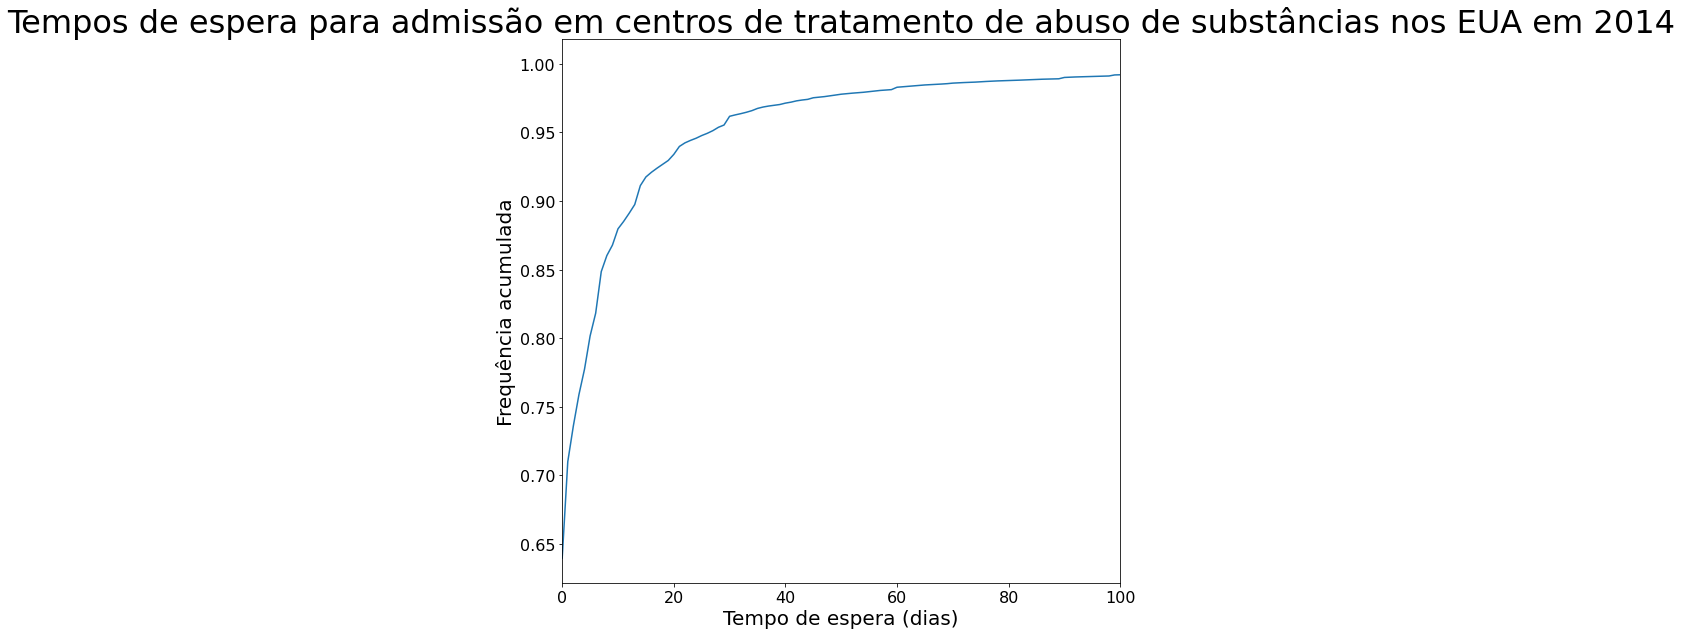

In [20]:
# Criamos um gráfico de densidade cumulativa dos tempos de espera de admissão

# Figura do plot
plt.figure(figsize=(10,10))

# Densidade acumulada
cdf = np.cumsum (counts)

# Plot
plt.plot(waits, cdf/cdf[-1]);
plt.xlim(0,100) 
plt.title("Tempos de espera para admissão em centros de tratamento de abuso de substâncias nos EUA em 2014", fontsize=32);
plt.xlabel("Tempo de espera (dias)", fontsize=20)
plt.ylabel("Frequência acumulada", fontsize=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

Esses dados sugerem que 65% das vezes que as pessoas procuraram tratamento para abuso de substâncias, elas puderam ser admitidas no mesmo dia. Dentro de aproximadamente uma semana, apenas 15% dos indivíduos ainda aguardavam tratamento. No entanto, esses últimos 15% das pessoas levaram muito tempo para serem admitidos. Esses dados são realmente truncados e houve tempos de espera desde que vários anos sejam registrados. Portanto, nem todas as pessoas que procuram tratamento são capazes de obter tratamento em tempo hábil.

## Por que os pacientes recebem alta?

Os pacientes sempre terminam com sucesso um tratamento ou existem outros motivos pelos quais recebem alta? A distribuição dos diferentes motivos da alta em todos os episódios de tratamento é apresentada abaixo.

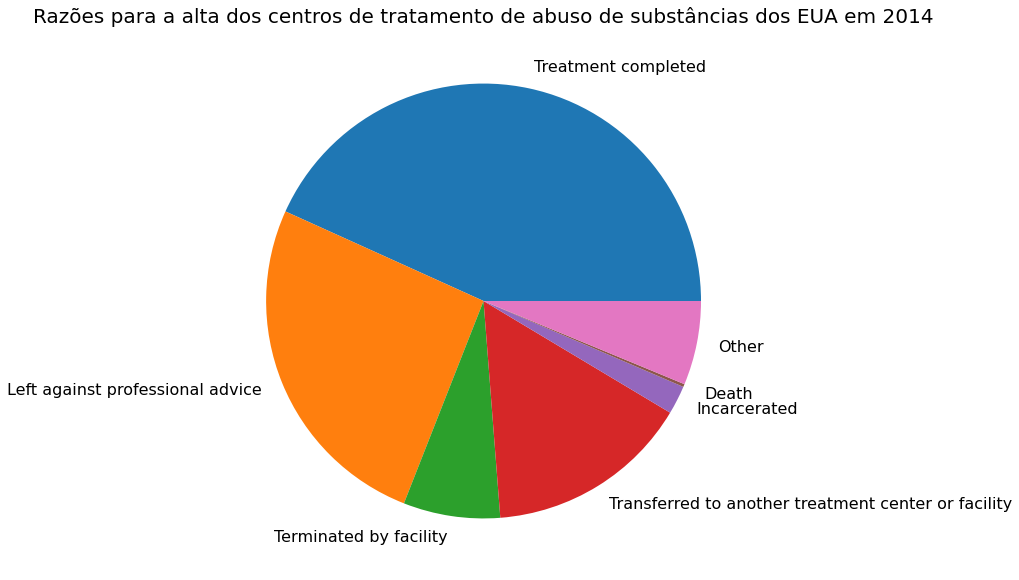

In [21]:
# Prepara os dados
cur.execute('SELECT REASON, COUNT(CASEID) from TEDSD_TB group by REASON');
reason_list = cur.fetchall();

# Lista de contagens
counts = []

# Carrega a lista com os dados
for item in reason_list:
    counts.append(item[1])

# Define o nome das razões
reason_name_list = ["Treatment completed",
                    "Left against professional advice",
                    "Terminated by facility",
                    "Transferred to another treatment center or facility",
                    "Incarcerated",
                    "Death",
                    "Other"]


plt.figure(figsize=(10,10))
plt.pie(counts, labels = reason_name_list, textprops = {'fontsize': 16});

plt.title("Razões para a alta dos centros de tratamento de abuso de substâncias dos EUA em 2014", fontsize=20);

Este gráfico mostra que muitas pessoas recebem alta por outras razões além de concluir o tratamento com sucesso ou serem transferidas para outro centro de tratamento. Isso inclui deixar um programa de aconselhamento profissional ou ser removido do programa por um centro devido à infração da regra, etc.

## Quantas internações anteriores em um centro de tratamento os pacientes tinham quando foram internados?

Quantas vezes um paciente foi internado anteriormente em um centro de tratamento dá alguma indicação da eficácia do tratamento anterior.

In [22]:
# As contagens de cada número de admissões anteriores
cur.execute('SELECT NOPRIOR, COUNT(CASEID) from TEDSD_TB group by NOPRIOR');
prior_list = cur.fetchall();

In [23]:
prior_list

[(-9, 113354),
 (0, 505092),
 (1, 313480),
 (2, 172547),
 (3, 107552),
 (4, 64049),
 (5, 203739)]

In [24]:
# Cria listas do número de admissões e contagens anteriores, com labels

priors = []
counts = []
labels = ['Nenhuma Internação', 'Uma Internação', 'Duas Internações', 'Três Internações', 'Quatro Internações', 'Cinco ou Mais Internações']

# Carrega as listas
for item in prior_list[1:len(prior_list)]:
    priors.append(labels[item[0]])
    counts.append(item[1])

In [25]:
priors

['Nenhuma Internação',
 'Uma Internação',
 'Duas Internações',
 'Três Internações',
 'Quatro Internações',
 'Cinco ou Mais Internações']

In [26]:
counts

[505092, 313480, 172547, 107552, 64049, 203739]

In [27]:
!pip install squarify

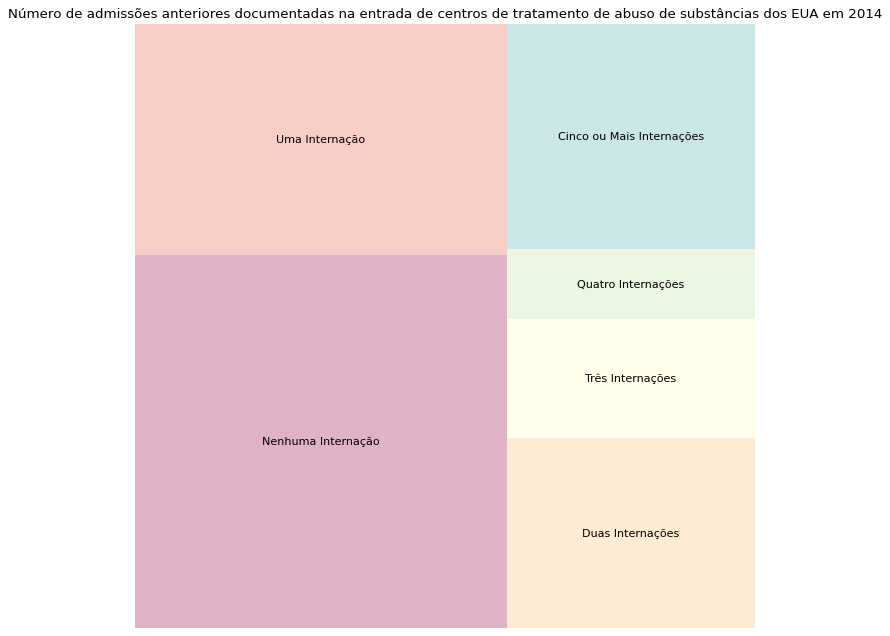

In [28]:
# Prepara os Dados
import squarify 

# Ajusta os dados do Plot
labels = priors
sizes = counts
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Plot
plt.figure(figsize = (10,10), dpi= 80)
squarify.plot(sizes = sizes, label = labels, color = colors, alpha = .3)

# Título
plt.title('Número de admissões anteriores documentadas na entrada de centros de tratamento de abuso de substâncias dos EUA em 2014')
plt.axis('off')
plt.show()

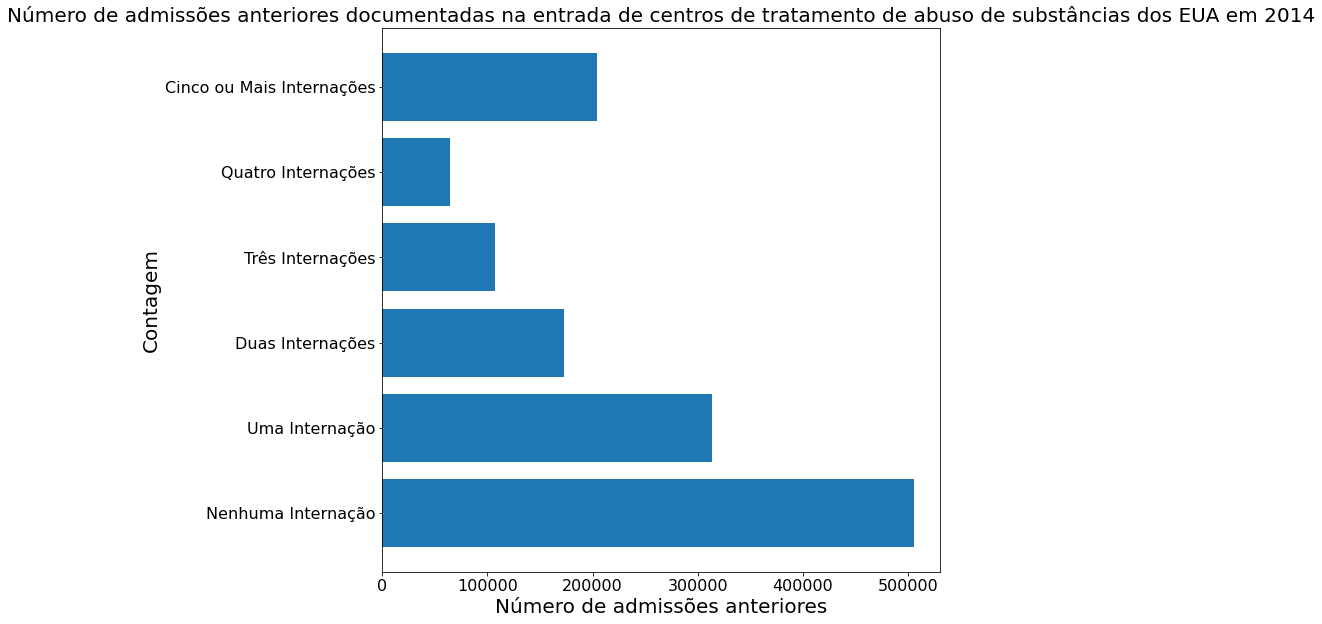

In [29]:
# Cria um gráfico de barras mostrando a distribuição de cada número de admissões anteriores

plt.figure(figsize=(10,10))
plt.barh(priors, counts);

plt.title("Número de admissões anteriores documentadas na entrada de centros de tratamento de abuso de substâncias dos EUA em 2014", fontsize=20);
plt.xlabel("Número de admissões anteriores", fontsize=20)
plt.ylabel("Contagem", fontsize=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

Este gráfico sugere que cerca de um terço das admissões em centros de tratamento eram para pessoas que procuram tratamento pela primeira vez, mas o restante tinha um histórico prévio de admissão em um centro de tratamento. Mais de 10% dos pacientes tiveram 5 ou mais admissões anteriores em um centro de tratamento. Para esses pacientes, o tratamento pode não ser eficaz para controlar seu vício.

## Qual é a distribuição dos tempos de permanência em um centro de tratamento?

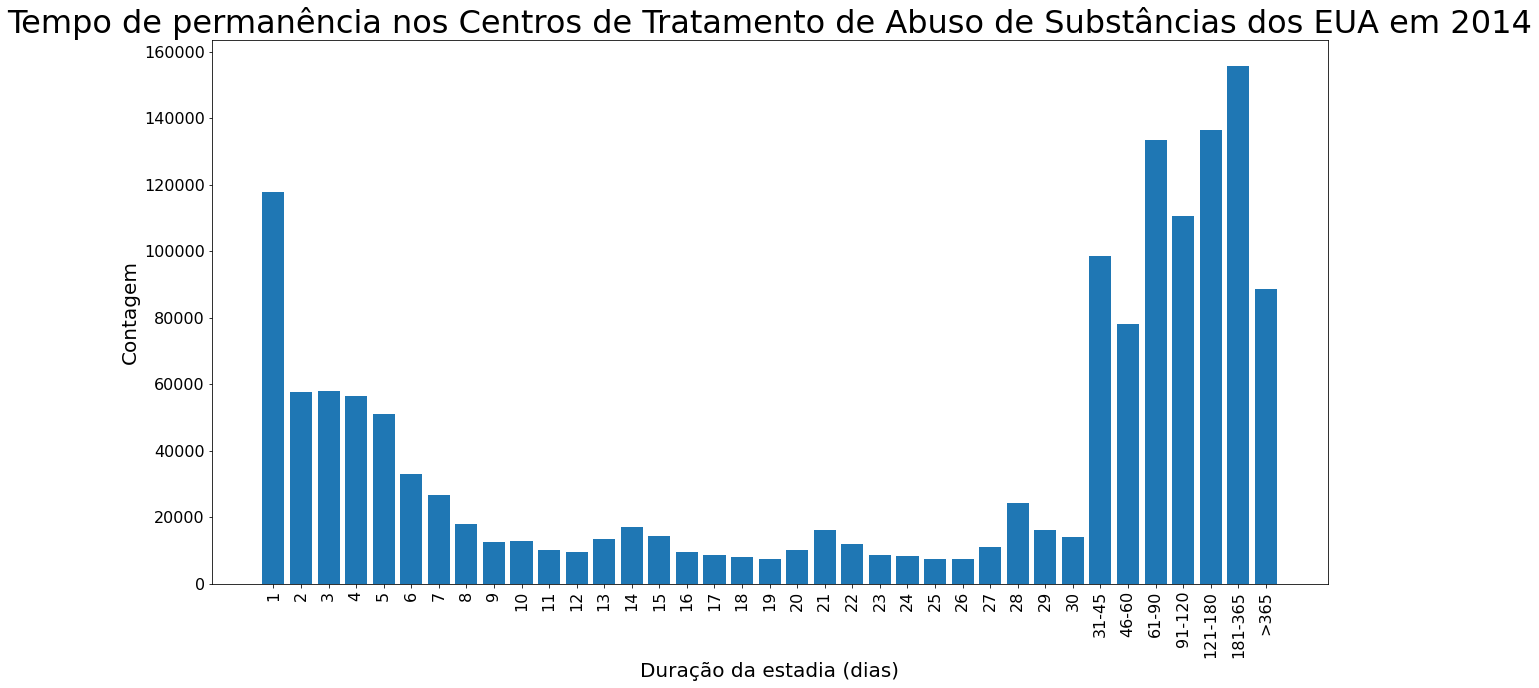

In [30]:
# Preparando os dados
cur.execute('SELECT LOS, COUNT(CASEID) from TEDSD_TB group by LOS');
los_list = cur.fetchall();

lengths = []
counts = []
sum_counts = 0

for item in los_list[1:len(los_list)]:
    lengths.append(str(item[0]))
    counts.append(item[1])
    sum_counts += int(item[1])

# A partir de 30 dias, criamos ranges de tempo de permanância nos centros de tratamento
last_bins = ['31-45', '46-60', '61-90', '91-120', '121-180', '181-365', '>365']

# Adiciona o range após 30 dias
lengths[30:len(lengths)] = last_bins

# Lista para as contagens normalizadas
norm_counts = []   

# Carrega a lista
for count in counts:
    norm_counts.append(count/sum_counts)

# Plot
plt.figure(figsize=(20,10))
plt.bar(lengths, counts)  
plt.title("Tempo de permanência nos Centros de Tratamento de Abuso de Substâncias dos EUA em 2014", fontsize=32);
plt.xlabel("Duração da estadia (dias)", fontsize=20)
plt.ylabel("Contagem", fontsize=20);
plt.xticks(fontsize=16, rotation=90);
plt.yticks(fontsize=16);

Parece ser uma distribuição aproximadamente exponencial das durações de permanência, já que os últimos compartimentos são intervalos de vários dias (é assim que os dados foram armazenados). Há um grande aumento no tempo de permanência de apenas um dia. São todas as pessoas que deixaram o tratamento contra orientação profissional? 

## Quais são os motivos da alta a cada período de internação?

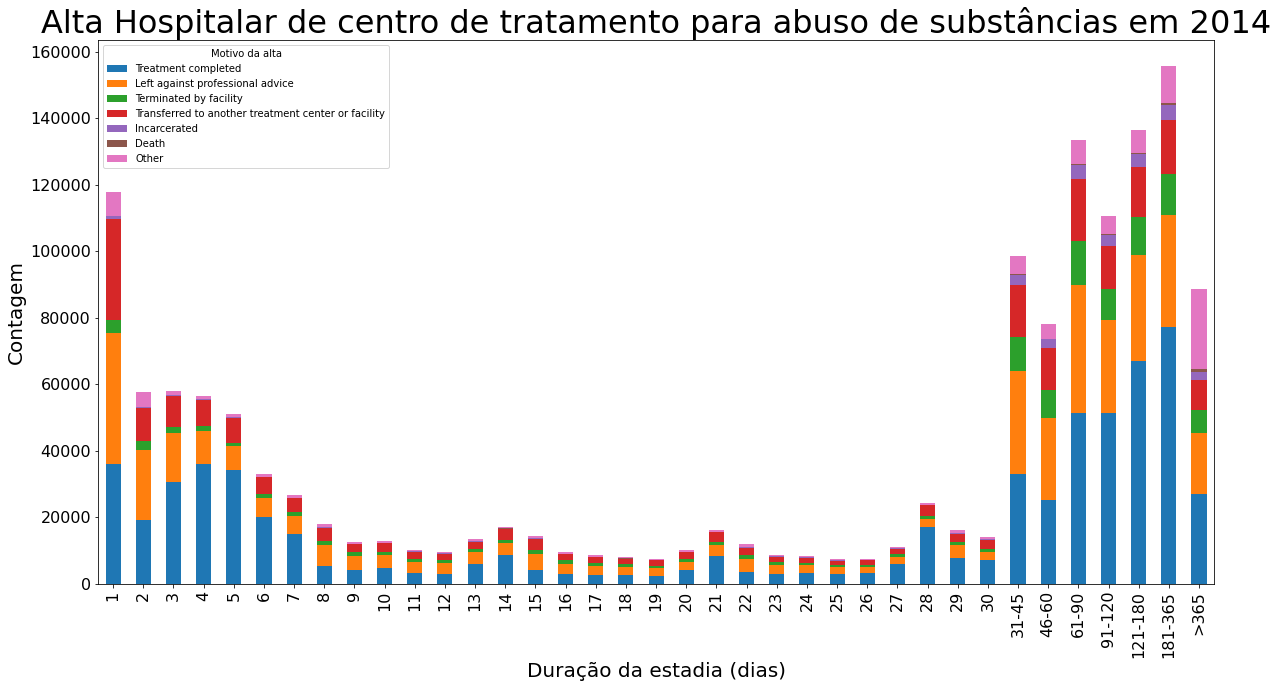

In [31]:
# Prepara os dados

df = pd.read_sql("""SELECT LOS, 
                 sum((REASON=1)) AS "Treatment completed", 
                 sum((REASON=2)) AS "Left against professional advice", 
                 sum((REASON=3)) AS "Terminated by facility",
                 sum((REASON=4)) AS "Transferred to another treatment center or facility",
                 sum((REASON=5)) AS "Incarcerated",
                 sum((REASON=6)) AS "Death",
                 sum((REASON=7)) AS "Other"
                 from TEDSD_TB group by LOS""", con=connection)

# Ajusta o dataframe
df = df.drop([0], axis=0)
df = df.drop('LOS', axis=1)

# Renomeia o índice
df = df.rename(index = dict(zip(np.arange(1,len(lengths)+1),lengths)))

# Stacked Bar
df.plot.bar(stacked="True", figsize=(20,10));
plt.xticks(fontsize=16);
plt.yticks(fontsize=16)
plt.title("Alta Hospitalar de centro de tratamento para abuso de substâncias em 2014", fontsize=32);
plt.ylabel("Contagem", fontsize=20);
plt.xlabel("Duração da estadia (dias)", fontsize=20)
plt.legend(title="Motivo da alta");

Surpreendentemente, uma fração similar de altas é classificada como pacientes que abandonam o aconselhamento profissional em todos os períodos de internação. Ainda mais surpreendentemente, uma proporção substancial de altas que ocorreram após um curto período de tratamento de uma semana ou até um ou dois dias é listada como conclusão bem-sucedida do tratamento. Isso levanta outras questões sobre esse conjunto de dados e padrões de tratamento.

# Fim